In [1]:
%pylab inline
import sncosmo
from sncosmo.photdata import standardize_data

from glob import glob


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
sdssLCfiles=glob("jla_light_curves/lc-SDSS*")

In [3]:
data = sncosmo.io.read_lc(sdssLCfiles[0], format='salt2')
tStart=data["Date"][0]

In [4]:
data

Date,Flux,Fluxerr,ZP,Filter,MagSys
float64,float64,float64,float64,str7,str6
53616.363,-9.51,36.432,27.5,SDSS::g,AB_B12
53616.363,78.37,54.62,27.5,SDSS::r,AB_B12
53616.363,-207.26,73.582,27.5,SDSS::i,AB_B12
53616.363,229.89,244.619,27.5,SDSS::z,AB_B12
53616.363,-12.09,73.278,27.5,SDSS::u,AB_B12
53626.34,-17.48,31.243,27.5,SDSS::g,AB_B12
53626.34,36.19,46.782,27.5,SDSS::r,AB_B12
53626.34,-191.41,62.266,27.5,SDSS::i,AB_B12
53626.34,210.35,184.727,27.5,SDSS::z,AB_B12


In [11]:
# Fix the filter and magsys names
data['Filter'] = ['sdss%s'%a[-1] for a in data['Filter']]
data['MagSys'] = ['ab' for a in data['MagSys']]
data['Date'] = data['Date']-tStart

In [12]:
# Fit the lc
# First need to add MW dust correction to model
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])

In [13]:
data.meta['Z_HELIO']

0.06533

In [14]:
# redshift and MW E(B-V) were in file header 
model.set(z=data.meta['Z_HELIO'], mwebv=data.meta['MWEBV'])
res, fitted_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'])

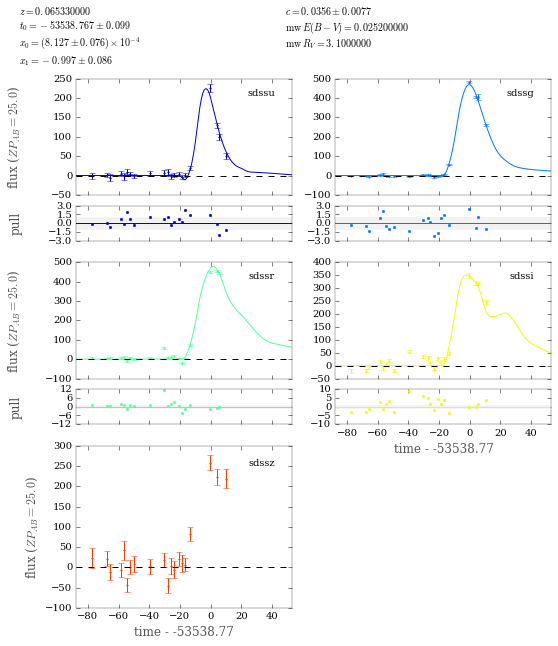

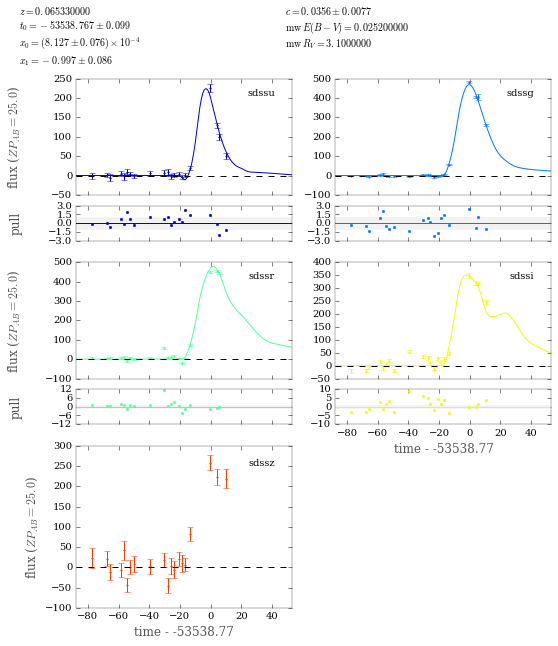

In [15]:
sncosmo.plot_lc(data, model=fitted_model, errors=res.errors)

In [16]:
model.bandflux?

In [17]:
newData

array([(0.0, 'sdssg', -0.9510000000000001, 3.6432, 25.0, 'ab'),
       (0.0, 'sdssr', 7.837000000000001, 5.462, 25.0, 'ab'),
       (0.0, 'sdssi', -20.726, 7.3582, 25.0, 'ab'),
       (0.0, 'sdssu', -1.209, 7.327800000000001, 25.0, 'ab'),
       (9.976999999998952, 'sdssg', -1.7480000000000002, 3.1243, 25.0, 'ab'),
       (9.976999999998952, 'sdssr', 3.6189999999999998, 4.6781999999999995, 25.0, 'ab'),
       (9.976999999998952, 'sdssi', -19.141000000000002, 6.2266, 25.0, 'ab'),
       (9.976999999998952, 'sdssu', 0.47100000000000003, 5.2799000000000005, 25.0, 'ab'),
       (11.961000000002969, 'sdssg', -5.9270000000000005, 4.1676, 25.0, 'ab'),
       (11.961000000002969, 'sdssr', 4.462, 5.5448, 25.0, 'ab'),
       (11.961000000002969, 'sdssi', -7.088, 6.7372000000000005, 25.0, 'ab'),
       (11.961000000002969, 'sdssu', -5.704000000000001, 8.6774, 25.0, 'ab'),
       (18.973000000005413, 'sdssg', 3.372, 3.5852, 25.0, 'ab'),
       (18.973000000005413, 'sdssr', 7.4750000000000005, 4.64

In [18]:
newData = sncosmo.photdata.standardize_data(data)
newData= sncosmo.photdata.normalize_data(newData)
newData=sncosmo.fitting.cut_bands(newData,model)

In [8]:
set(newData['band'])

{'sdssg', 'sdssi', 'sdssr', 'sdssu'}

In [9]:
fitted_model.bandflux(newData['band'],newData['time'])

NameError: name 'fitted_model' is not defined

In [10]:
data.meta['MWEBV']

0.0252

In [65]:
fitted_model.param_names

['z', 't0', 'x0', 'x1', 'c', 'mwebv', 'mwr_v']

In [19]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import scipy.optimize as optimize


In [20]:
#@as_op(itypes=[T.dscalar,T.dscalar,T.dscalar,T.dscalar],otypes=[T.dvector])
def get_flux(t0,x0,x1,c):
    
    model.parameters = [data.meta['Z_HELIO'],t0,x0,x1,c,data.meta['MWEBV'],3.1]
    return model.bandflux(newData['band'],newData['time'],zp=newData['zp'],zpsys=newData['zpsys'])
    
#get_flux.grad=lambda *x: x[0]  
    
    

In [ ]:
lcModel= pm.Model()


with lcModel:
    
    #z  = pm.Uniform('z',lower=0.,upper=1.)
    t0 = pm.Uniform('t0',lower=newData['time'].min(),upper=newData['time'].max())
    x0 = pm.Uniform('x0',lower=1E-5, upper=1E-3)
    x1 = pm.Normal('x1',mu=0., sd=3.)
    c  = pm.Normal('c',mu=0., sd=1.)
    
    #sigma = pm.HalfCauchy('sigma',beta=2.5,shape=len(newData['flux']))
    
    #mwebv  = pm.Normal('mwebv',mu=0.,sd=1)
    #mwr  = pm.Normal('mwr',mu=3.,sd=1)
    
    points = pm.Normal('points',mu=get_flux(t0,x0,x1,c),sd=newData['fluxerr'],observed=newData['flux'])
    #points = pm.Normal('points',mu=get_flux(t0,x0,x1,c),sd=sigma,observed=newData['flux'])
    
    
    
    
    


In [62]:
with lcModel:
    
    start=pm.find_MAP(fmin=optimize.fmin_powell)
    

In [63]:
start

{'c': array(-0.040740447134048265),
 't0_interval': array(-1.288948397260178),
 'x0_interval': array(-1.34123355631493),
 'x1': array(0.8226304307875311)}

In [64]:
with lcModel:
    
    #step=pm.Slice()
    trace=pm.sample(5000,start=start,progressbar=True)
    
    

 [-----------------100%-----------------] 5000 of 5000 complete in 194.8 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c650a50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1244c5950>]], dtype=object)

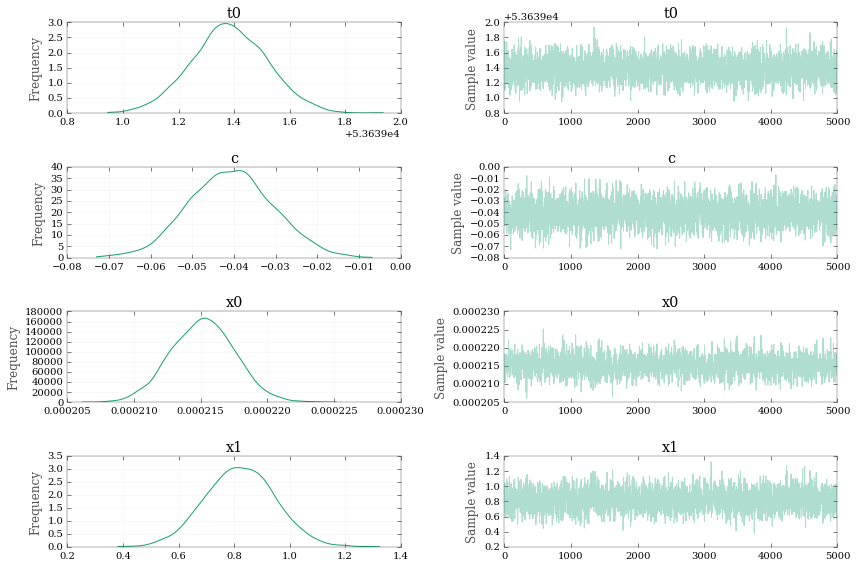

In [45]:

pm.traceplot(trace[5000:],vars=['t0','c','x0','x1'])

In [47]:
pm.summary(trace[5000:],vars=['t0','c','x0','x1'])


t0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  53640.384        0.137            0.003            [53640.131, 53640.670]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  53640.114      53640.295      53640.382      53640.477      53640.654


c:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.041           0.010            0.000            [-0.060, -0.020]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.060         -0.048         -0.041         -0.034         -0.021


x0:

  Mean             SD               MC Error         95% HPD interval
  --------------------

In [126]:
10**-3.668

0.00021478304741305332

In [67]:
bands= unique(newData['band'])
times = linspace(newData['time'].min(),newData['time'].max(),100)


In [66]:
newData['time']

array([  0.   ,   0.   ,   0.   ,   0.   ,   4.957,   4.957,   4.957,
         4.957,  11.949,  11.949,  11.949,  11.949,  15.992,  15.992,
        15.992,  15.992,  17.957,  17.957,  17.957,  17.957,  20.996,
        20.996,  20.996,  20.996,  24.015,  24.015,  24.015,  24.015,
        34.836,  34.836,  34.836,  35.   ,  35.   ,  35.   ,  35.   ,
        41.019,  41.019,  41.019,  41.019,  41.953,  43.019,  43.019,
        43.019,  43.019,  46.007,  46.007,  46.007,  46.007,  46.914,
        46.914,  46.914,  46.914,  48.011,  48.011,  48.011,  48.011,
        48.996,  48.996,  48.996,  48.996,  51.898,  51.898,  51.898,
        51.898,  53.988,  53.988,  53.988,  53.988,  56.957,  56.957,
        56.957,  56.957,  58.949,  58.949,  58.949,  58.949,  61.91 ,
        61.91 ,  61.91 ,  61.91 ,  64.851,  64.851,  64.851,  64.851,
        73.914,  73.914,  73.914,  73.914,  74.906,  74.906,  74.906,
        74.906,  77.906,  77.906,  77.906,  77.906,  82.89 ,  82.89 ,
        82.89 ,  82.

In [1]:
burnin = 2500
thin=50

whichBand=0

unwanted=['t0_interval','x0_interval']
for tr in trace[burnin::thin]:
    for x in unwanted: del tr[x]
    
    model.set(**tr)
    
    plot(times,model.bandflux(bands[whichBand],times,zp=newData['zp'],zpsys=newData['zpsys']),'k-',alpha=0.05)

tt = newData['band'] == bands[whichBand]
errorbar(newData['time'][tt],newData['flux'][tt],yerr=newData['fluxerr'][tt],fmt='.')
    
    
    
    


NameError: name 'trace' is not defined

(0.0, 50)

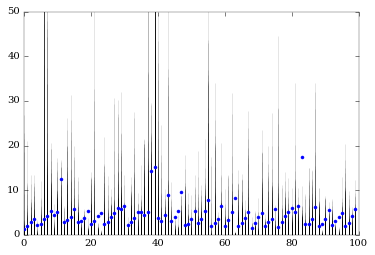

In [36]:
for tr in trace['sigma'][burnin::thin]:
    
    vlines(arange(len(tr)),[0]*len(tr),tr,'k',alpha=.1)
    
plot(arange(len(newData['fluxerr'])),newData['fluxerr'],'b.')

ylim(top=50)



In [38]:
fitted_model.bandmag?

In [169]:
tt

'sdssg'

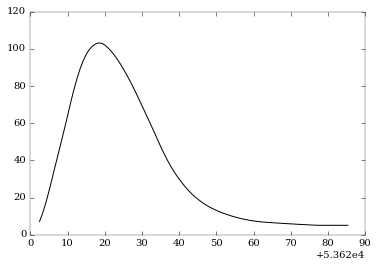

In [161]:
plot(times,model.bandflux(bands[0],times,zp=newData['zp'],zpsys=newData['zpsys']),'k-')

In [159]:
from astropy.cosmology.funcs import l

TypeError: 'set' object does not support indexing